<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ElasticNet Models with Box Score Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Expanding Training Window](#Inspect-Training-Windows)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**
  
**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    file_path='../../data/processed/nba_team_matchups_rolling_adv_stats_2021_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    feature_prefix='ROLL_',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.685,0.715,0.717,0.728,0.457,0.417,0.448,0.362,0.582,0.376,0.666,0.598,0.297,0.277,0.679,0.712,0.0,0.625,0.740,0.879,0.879,0.424,0.502,0.691,0.700,0.684,0.462,0.513,0.652,0.654,0.826,0.589,0.769,0.347,0.478,0.498,0.256,0.260,0.618,0.670,0.0,0.2,0.465,0.430,0.430,0.349,0.746,0.635,239
2021-10-23,0.762,0.727,0.298,0.315,0.779,0.698,0.624,0.215,0.597,0.570,0.286,0.380,0.573,0.532,0.769,0.808,0.0,1.000,0.763,1.000,1.000,0.485,0.780,0.745,0.672,0.611,0.881,0.875,0.311,0.319,0.535,0.291,0.571,0.334,0.482,0.343,0.519,0.500,0.712,0.714,0.0,0.6,0.443,0.515,0.515,0.379,0.330,0.577,185
2021-10-23,0.849,0.987,0.328,0.402,0.827,0.833,0.719,1.000,0.888,0.955,0.197,0.542,0.055,0.046,0.739,0.683,0.0,0.750,0.367,0.242,0.242,0.121,0.787,0.727,0.279,0.277,0.894,0.944,0.000,0.000,0.474,0.218,0.265,0.000,0.339,0.000,0.383,0.388,0.210,0.256,0.0,0.7,0.691,0.641,0.641,0.438,0.000,0.250,232
2021-10-23,0.000,0.000,0.176,0.192,0.286,0.242,0.201,0.000,0.000,0.620,0.679,0.408,0.617,0.595,0.000,0.000,0.0,0.875,0.732,0.909,0.909,0.455,0.000,0.000,0.183,0.152,0.566,0.583,0.176,0.182,0.284,0.161,0.116,0.262,0.918,0.394,0.404,0.393,0.000,0.035,0.0,0.8,0.522,0.557,0.557,0.408,0.060,0.096,198
2021-10-24,0.708,0.791,0.002,0.101,0.931,0.886,0.582,0.298,0.724,0.686,0.590,0.804,0.498,0.503,0.836,0.797,0.0,0.500,0.812,0.758,0.758,0.394,0.978,0.745,0.543,0.600,0.555,0.614,0.461,0.509,0.753,0.393,0.571,0.596,0.424,0.423,0.371,0.398,0.416,0.414,0.0,0.6,0.646,0.516,0.516,1.000,0.471,1.000,204


In [5]:
pm_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.685,0.715,0.717,0.728,0.457,0.417,0.448,0.362,0.582,0.376,0.666,0.598,0.297,0.277,0.679,0.712,0.0,0.625,0.740,0.879,0.879,0.424,0.502,0.691,0.700,0.684,0.462,0.513,0.652,0.654,0.826,0.589,0.769,0.347,0.478,0.498,0.256,0.260,0.618,0.670,0.0,0.2,0.465,0.430,0.430,0.349,0.746,0.635,29.0
2021-10-23,0.762,0.727,0.298,0.315,0.779,0.698,0.624,0.215,0.597,0.570,0.286,0.380,0.573,0.532,0.769,0.808,0.0,1.000,0.763,1.000,1.000,0.485,0.780,0.745,0.672,0.611,0.881,0.875,0.311,0.319,0.535,0.291,0.571,0.334,0.482,0.343,0.519,0.500,0.712,0.714,0.0,0.6,0.443,0.515,0.515,0.379,0.330,0.577,7.0
2021-10-23,0.849,0.987,0.328,0.402,0.827,0.833,0.719,1.000,0.888,0.955,0.197,0.542,0.055,0.046,0.739,0.683,0.0,0.750,0.367,0.242,0.242,0.121,0.787,0.727,0.279,0.277,0.894,0.944,0.000,0.000,0.474,0.218,0.265,0.000,0.339,0.000,0.383,0.388,0.210,0.256,0.0,0.7,0.691,0.641,0.641,0.438,0.000,0.250,-10.0
2021-10-23,0.000,0.000,0.176,0.192,0.286,0.242,0.201,0.000,0.000,0.620,0.679,0.408,0.617,0.595,0.000,0.000,0.0,0.875,0.732,0.909,0.909,0.455,0.000,0.000,0.183,0.152,0.566,0.583,0.176,0.182,0.284,0.161,0.116,0.262,0.918,0.394,0.404,0.393,0.000,0.035,0.0,0.8,0.522,0.557,0.557,0.408,0.060,0.096,-8.0
2021-10-24,0.708,0.791,0.002,0.101,0.931,0.886,0.582,0.298,0.724,0.686,0.590,0.804,0.498,0.503,0.836,0.797,0.0,0.500,0.812,0.758,0.758,0.394,0.978,0.745,0.543,0.600,0.555,0.614,0.461,0.509,0.753,0.393,0.571,0.596,0.424,0.423,0.371,0.398,0.416,0.414,0.0,0.6,0.646,0.516,0.516,1.000,0.471,1.000,-10.0


In [6]:
res_scaled_df.head()

,ROLL_HOME_estimatedOffensiveRating,ROLL_HOME_offensiveRating,ROLL_HOME_estimatedDefensiveRating,ROLL_HOME_defensiveRating,ROLL_HOME_estimatedNetRating,ROLL_HOME_netRating,ROLL_HOME_assistPercentage,ROLL_HOME_assistToTurnover,ROLL_HOME_assistRatio,ROLL_HOME_offensiveReboundPercentage,ROLL_HOME_defensiveReboundPercentage,ROLL_HOME_reboundPercentage,ROLL_HOME_estimatedTeamTurnoverPercentage,ROLL_HOME_turnoverRatio,ROLL_HOME_effectiveFieldGoalPercentage,ROLL_HOME_trueShootingPercentage,ROLL_HOME_usagePercentage,ROLL_HOME_estimatedUsagePercentage,ROLL_HOME_estimatedPace,ROLL_HOME_pace,ROLL_HOME_pacePer40,ROLL_HOME_possessions,ROLL_HOME_PIE,ROLL_HOME_PTS,ROLL_AWAY_estimatedOffensiveRating,ROLL_AWAY_offensiveRating,ROLL_AWAY_estimatedDefensiveRating,ROLL_AWAY_defensiveRating,ROLL_AWAY_estimatedNetRating,ROLL_AWAY_netRating,ROLL_AWAY_assistPercentage,ROLL_AWAY_assistToTurnover,ROLL_AWAY_assistRatio,ROLL_AWAY_offensiveReboundPercentage,ROLL_AWAY_defensiveReboundPercentage,ROLL_AWAY_reboundPercentage,ROLL_AWAY_estimatedTeamTurnoverPercentage,ROLL_AWAY_turnoverRatio,ROLL_AWAY_effectiveFieldGoalPercentage,ROLL_AWAY_trueShootingPercentage,ROLL_AWAY_usagePercentage,ROLL_AWAY_estimatedUsagePercentage,ROLL_AWAY_estimatedPace,ROLL_AWAY_pace,ROLL_AWAY_pacePer40,ROLL_AWAY_possessions,ROLL_AWAY_PIE,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.685,0.715,0.717,0.728,0.457,0.417,0.448,0.362,0.582,0.376,0.666,0.598,0.297,0.277,0.679,0.712,0.0,0.625,0.740,0.879,0.879,0.424,0.502,0.691,0.700,0.684,0.462,0.513,0.652,0.654,0.826,0.589,0.769,0.347,0.478,0.498,0.256,0.260,0.618,0.670,0.0,0.2,0.465,0.430,0.430,0.349,0.746,0.635,1
2021-10-23,0.762,0.727,0.298,0.315,0.779,0.698,0.624,0.215,0.597,0.570,0.286,0.380,0.573,0.532,0.769,0.808,0.0,1.000,0.763,1.000,1.000,0.485,0.780,0.745,0.672,0.611,0.881,0.875,0.311,0.319,0.535,0.291,0.571,0.334,0.482,0.343,0.519,0.500,0.712,0.714,0.0,0.6,0.443,0.515,0.515,0.379,0.330,0.577,1
2021-10-23,0.849,0.987,0.328,0.402,0.827,0.833,0.719,1.000,0.888,0.955,0.197,0.542,0.055,0.046,0.739,0.683,0.0,0.750,0.367,0.242,0.242,0.121,0.787,0.727,0.279,0.277,0.894,0.944,0.000,0.000,0.474,0.218,0.265,0.000,0.339,0.000,0.383,0.388,0.210,0.256,0.0,0.7,0.691,0.641,0.641,0.438,0.000,0.250,0
2021-10-23,0.000,0.000,0.176,0.192,0.286,0.242,0.201,0.000,0.000,0.620,0.679,0.408,0.617,0.595,0.000,0.000,0.0,0.875,0.732,0.909,0.909,0.455,0.000,0.000,0.183,0.152,0.566,0.583,0.176,0.182,0.284,0.161,0.116,0.262,0.918,0.394,0.404,0.393,0.000,0.035,0.0,0.8,0.522,0.557,0.557,0.408,0.060,0.096,0
2021-10-24,0.708,0.791,0.002,0.101,0.931,0.886,0.582,0.298,0.724,0.686,0.590,0.804,0.498,0.503,0.836,0.797,0.0,0.500,0.812,0.758,0.758,0.394,0.978,0.745,0.543,0.600,0.555,0.614,0.461,0.509,0.753,0.393,0.571,0.596,0.424,0.423,0.371,0.398,0.416,0.414,0.0,0.6,0.646,0.516,0.516,1.000,0.471,1.000,0


# Inspect Expanding Training Window

[Return to top](#Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Models)

In [8]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_pts_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for total points with expanding window
model = ElasticNet(**best_params)  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 1999.23 seconds


In [9]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 21.02
- Null RMSE: 20.28


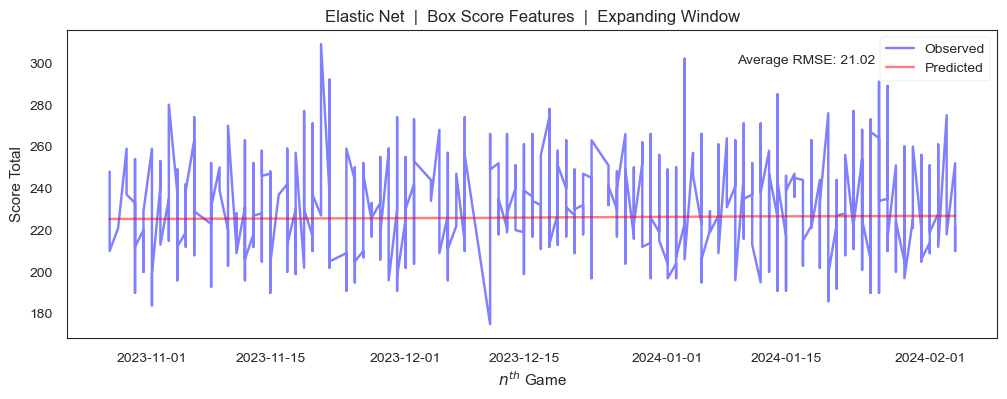

In [10]:
utl.plot_model_performance(
    title='Elastic Net  |  Advanced Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Models)

In [ ]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_pm_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for points difference with expanding window
model = ElasticNet(**best_params)  # model class
target_col = 'PLUS_MINUS'    # target column name
df = pm_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

In [ ]:
metrics = utl.calculate_metrics(y_true, model_outputs)

In [ ]:
utl.plot_model_performance(
    title='Elastic Net  |  Advanced Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'], 
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Models)

In [ ]:
# load the best hyperparameters dictionary back from the file
with open('../../hyperparameters/ELN_res_best_params_advanced.json', 'r') as json_file:
    best_params = json.load(json_file)

# configuration for game winner with expanding window
model = LogisticRegression(**best_params)  # model class
target_col = 'GAME_RESULT'    # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

In [ ]:
metrics = utl.calculate_metrics(y_true, model_outputs)

In [ ]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Elastic Net  |  Box Score Features  |  Expanding Window'
)

In [ ]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/ElasticNet_preds_advanced_stats.csv', index=False)